In [2]:
import os
import gzip
import urllib.request
from collections import defaultdict
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

# Excercise 1.
Import the data, draw their histogram.

data source - https://snap.stanford.edu/data/soc-Pokec.html

In [3]:
url = "https://snap.stanford.edu/data/soc-pokec-relationships.txt.gz"
gz_file = "pokec.txt.gz"
txt_file = "pokec.txt"

if not os.path.exists(gz_file):
    urllib.request.urlretrieve(url, gz_file)

if not os.path.exists(txt_file):
    with gzip.open(gz_file, "rt") as f_in, open(txt_file, "w") as f_out:
        for line in f_in:
            f_out.write(line)

degcount = {}

with open(txt_file, "r") as f:
    for line in f:
        if line.startswith("#") or not line.strip():
            continue
        u, v = map(int, line.split())
        degcount[u] = degcount.get(u, 0) + 1
        degcount[v] = degcount.get(v, 0) + 1


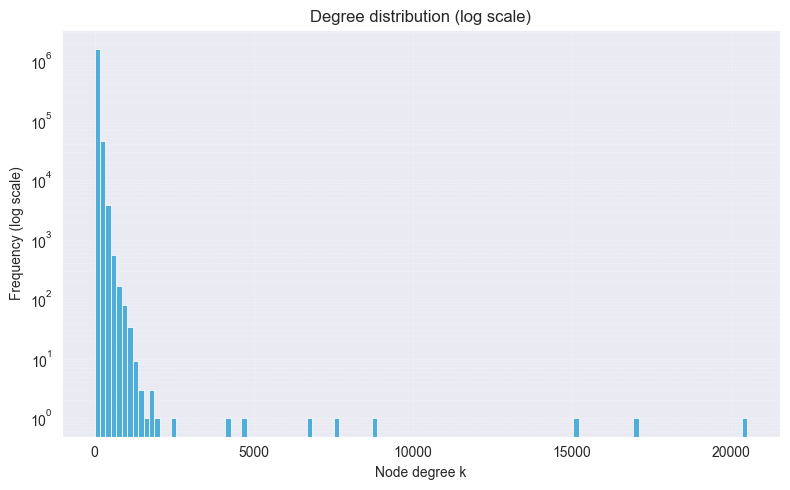

In [4]:
degrees = list(degcount.values())

def plot_degree_histogram_log(degrees, bins=120, title="Degree distribution (log scale)"):
    plt.figure(figsize=(8, 5))

    plt.hist(
        degrees,
        bins=bins,
        log=True,
        color="#3fa7d6",
        edgecolor="white",
        linewidth=0.6,
        alpha=0.9
    )

    plt.xlabel("Node degree k")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)

    plt.grid(True, which="both", linestyle="--", linewidth=0.4, alpha=0.4)
    plt.tight_layout()
    plt.show()


plot_degree_histogram_log(degrees)




# Excercise 2.
Correct the scale of the plot’s axes to double logarithmic.

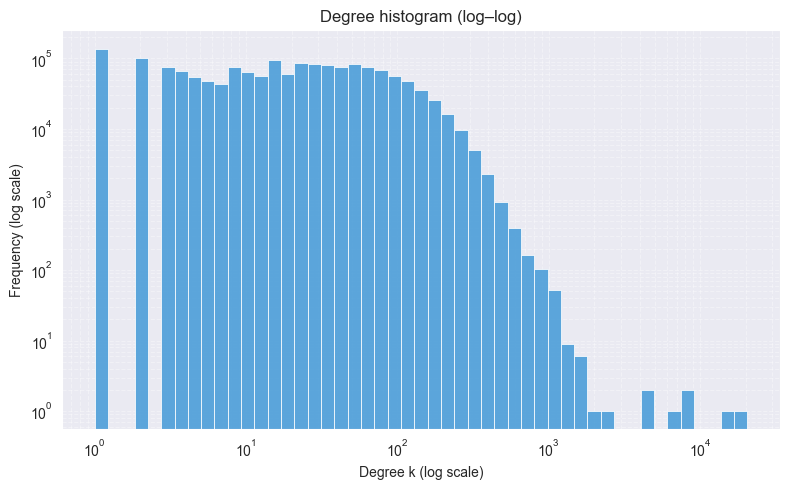

In [30]:
def plot_degree_histogram_loglog(degrees, bins=50, title="Degree histogram (log–log)"):

    max_degree = max(degrees)
    bins = np.logspace(np.log10(1), np.log10(max_degree), num=bins)

    plt.figure(figsize=(8, 5))

    plt.hist(
        degrees,
        bins=bins,
        color="#4c9ed9",
        edgecolor="white",
        linewidth=0.6,
        alpha=0.9
    )

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("Degree k (log scale)")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)

    plt.grid(True, which="both", linestyle="--", alpha=0.35)
    plt.tight_layout()
    plt.show()


plot_degree_histogram_loglog(degrees)



# Excercise 3.
Apply logarithmic binning as well.

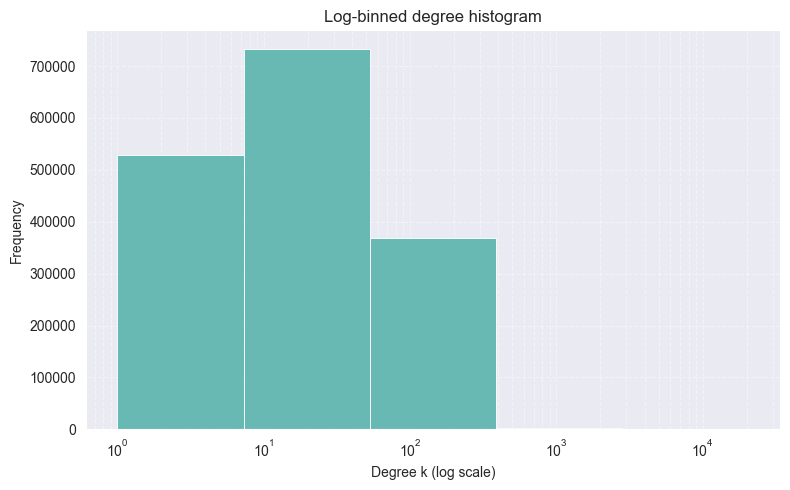

In [31]:
def plot_log_binned_histogram(degrees, num_bins=6, title="Log-binned degree histogram"):

    max_degree = max(degrees)
    min_degree = max(min(degrees), 1)

    bins = np.logspace(np.log10(min_degree), np.log10(max_degree), num=num_bins)

    plt.figure(figsize=(8, 5))

    plt.hist(
        degrees,
        bins=bins,
        color="#5ab4ac",
        edgecolor="white",
        linewidth=0.7,
        alpha=0.9
    )

    plt.xscale("log")
    plt.xlabel("Degree k (log scale)")
    plt.ylabel("Frequency")
    plt.title(title)

    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


plot_log_binned_histogram(degrees)


# Excercise 4.
Compute and draw the survival function.

**Survival function (CCDF):**

$$
S(k) = P(K \ge k) = \frac{\sum_{x \ge k} n_x}{N}
$$

where
- \( n_x \) = number of nodes with degree \( x \),
- \( N \) = total number of nodes.


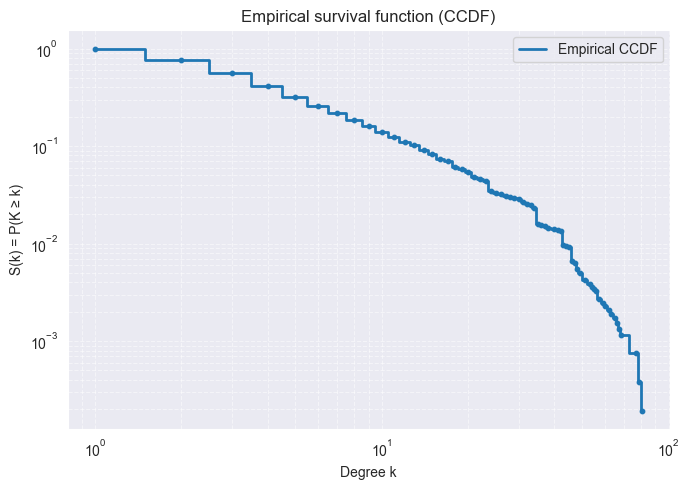

In [35]:
def compute_survival_function(degrees):
    degrees = np.asarray(degrees)
    degrees_sorted = np.sort(degrees)

    unique_degrees, degree_counts = np.unique(degrees_sorted, return_counts=True)

    nodes_at_risk = np.cumsum(degree_counts[::-1])[::-1].astype(float)

    survival_empirical = nodes_at_risk / nodes_at_risk[0]

    return unique_degrees, survival_empirical


def plot_survival(degrees, title="Empirical survival function (CCDF)"):
    k, S = compute_survival_function(degrees)

    mask = (k > 0) & (S > 0)
    k = k[mask]
    S = S[mask]

    k = k[::-1]
    S = S[::-1]

    plt.figure(figsize=(7, 5))
    plt.step(k, S, where="mid", lw=2, color="#1f77b4", label="Empirical CCDF")
    plt.scatter(k, S, s=10, color="#1f77b4")

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("Degree k")
    plt.ylabel("S(k) = P(K ≥ k)")
    plt.title(title)

    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return k[::-1], S[::-1]


k_vals, S_vals = plot_survival(degrees)

# Exercise 5
Which chart is the most readable? Which is most robust for the
noise?

**Most readable plot:**
- **Log–log histogram**
  $$\text{Histogram on log–log axes is easiest to interpret.}$$

**Most noise-robust plot:**
- **Survival function (CCDF)**
  $$S(k) = P(K \ge k) \quad \text{smooths noise and is stable in the tail.}$$



# Excercise 6.
Use the linear regression to the previous plots to determine the
parameter α estimator.


## Power-law fit from survival function — theory

We assume the tail of the degree distribution follows a power law:

$$
P(k) \propto k^{-\alpha}, \qquad k \ge k_{\min}.
$$

Instead of fitting the PDF, we use the **survival function** (CCDF):

$$
S(k) = P(K \ge k).
$$

For a power-law distribution, the CCDF is also a power law:

$$
S(k) \sim k^{-(\alpha - 1)}.
$$

because

$$
S(k) \approx \int_k^\infty C\,x^{-\alpha}\,dx
      = \frac{C}{\alpha - 1}\,k^{-(\alpha - 1)}.
$$

---

## Log–log transformation

Taking base-10 logarithms gives a straight-line model:

$$
\log_{10} S(k)
= \log_{10} C' - (\alpha - 1)\,\log_{10} k.
$$

Define

$$
X = \log_{10} k, \qquad Y = \log_{10} S(k),
$$

then the linear form is:

$$
Y = \text{slope}\cdot X + \text{intercept}.
$$

where

$$
\text{slope} = -(\alpha - 1)
\quad\Rightarrow\quad
\boxed{\alpha = 1 - \text{slope}}.
$$

---

## Corresponding regression code

```python
X = np.log10(k)
Y = np.log10(S)

A = np.vstack([X, np.ones_like(X)]).T
slope, intercept = np.linalg.lstsq(A, Y, rcond=None)[0]

alpha_est = 1 - slope


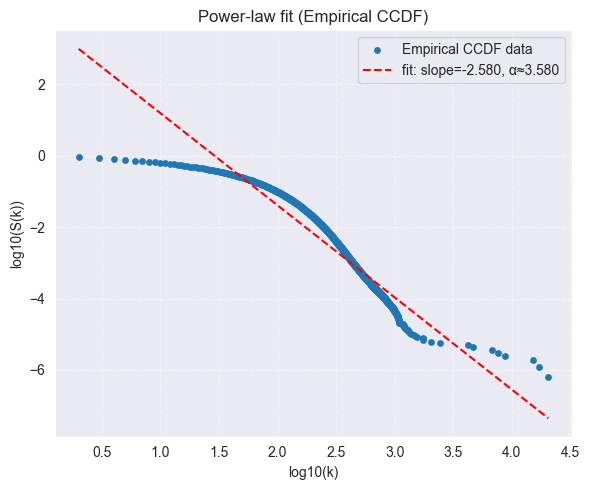

[Empirical CCDF] α ≈ 3.580, slope = -2.580, R² = 0.902


In [36]:
import numpy as np
import matplotlib.pyplot as plt

def compute_survival_function(degrees):
    degrees = np.asarray(degrees)
    degrees_sorted = np.sort(degrees)
    k, counts = np.unique(degrees_sorted, return_counts=True)
    at_risk = np.cumsum(counts[::-1])[::-1].astype(float)
    S = at_risk / at_risk[0]
    return k, S

def fit_power_law_from_survival(unique_degrees, survival_values, xmin=2, label="Empirical CCDF"):
    mask = (unique_degrees >= xmin) & (survival_values > 0)
    k = unique_degrees[mask]
    S = survival_values[mask]

    X = np.log10(k)
    Y = np.log10(S)
    A = np.vstack([X, np.ones_like(X)]).T
    slope, intercept = np.linalg.lstsq(A, Y, rcond=None)[0]
    alpha_est = 1 - slope

    Y_pred = slope * X + intercept
    ss_res = np.sum((Y - Y_pred) ** 2)
    ss_tot = np.sum((Y - Y.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    plt.figure(figsize=(6, 5))
    plt.scatter(X, Y, s=15, label=f"{label} data")
    plt.plot(X, Y_pred, "r--", label=f"fit: slope={slope:.3f}, α≈{alpha_est:.3f}")
    plt.xlabel("log10(k)")
    plt.ylabel("log10(S(k))")
    plt.title(f"Power-law fit ({label})")
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"[{label}] α ≈ {alpha_est:.3f}, slope = {slope:.3f}, R² = {r2:.3f}")
    return {"alpha": alpha_est, "slope": slope, "intercept": intercept, "r2": r2}

degrees = list(degcount.values())
k_vals, S_vals = compute_survival_function(degrees)
result = fit_power_law_from_survival(k_vals, S_vals, xmin=2, label="Empirical CCDF")


# Excercise 7
Compute (formula and value for our data) MLE estimator for α with
aknown xmin assuming following distribution
P(x) = α − 1
xmin (
x
xmin )−α
.

We assume that the degree distribution in the tail follows a continuous Pareto law:

$$
P(x) = \frac{\alpha - 1}{x_{\min}}
\left( \frac{x}{x_{\min}} \right)^{-\alpha},
\qquad x \ge x_{\min}.
$$

For this distribution, the Maximum Likelihood Estimator (MLE) of \( \alpha \) (for a fixed, known \( x_{\min} \)) is:

$$
\hat{\alpha}
= 1 +
\frac{n}{\sum\limits_{i=1}^n \ln\left( \frac{x_i}{x_{\min}} \right)},
$$

where

- \( x_i \ge x_{\min} \) are observations in the tail (here: node degrees),
- \( n \) is the number of such observations.

An approximate standard error of this estimator is:
$$
\operatorname{SE}(\hat{\alpha}) \approx \frac{\hat{\alpha} - 1}{\sqrt{n}}.
$$

Article - https://arxiv.org/abs/0706.1062 - Clauset, Shalizi & Newman (2009), Power-Law Distributions in Empirical Data


derivation on the paper

In [7]:
def mle_est(data, xmin):
    x = np.asarray(data, dtype=float)
    x_tail = x[x >= xmin]
    n = x_tail.size
    if n < 1:
        return np.nan, np.nan, 0

    logs = np.log(x_tail / float(xmin))
    S = np.sum(logs)

    if S == 0:
        return np.nan, np.nan, n

    alpha_hat = 1.0 + n / S
    se = (alpha_hat - 1.0) / np.sqrt(n)
    return alpha_hat, se, n

xmin = 50
alpha_hat, se_hat, n_tail = mle_est(degrees, xmin)

print(f"α_MLE ≈ {alpha_hat:.4f}  (SE ≈ {se_hat:.4f}, n_tail = {n_tail})")


α_MLE ≈ 2.5744  (SE ≈ 0.0025, n_tail = 402955)


# Exercise 8
How will the result change if we do not know xmin?


## Power-law parameter estimation when \(x_{\min}\) is unknown
*(Clauset–Shalizi–Newman method)*

### **Step 1 — Select the tail**

Keep only the values in the tail:

$$
x_i \ge x_{\min}
$$

---

### **Step 2 — Estimate \(\alpha\) using the MLE formula**

The maximum likelihood estimator of the power-law exponent is:

$$
\hat{\alpha}
=
1
+
\frac{n}
{\displaystyle \sum_{i=1}^{n} \ln\!\left(\frac{x_i}{x_{\min}}\right)},
$$

where:

- \(n\) is the number of tail samples (those satisfying \(x_i \ge x_{\min}\)).

---

### **Step 3 — Compute the empirical tail CCDF**

$$
S_{\text{emp}}(x)
$$

This is the complementary cumulative distribution function of the data restricted to \(x \ge x_{\min}\).

---

### **Step 4 — Compute the theoretical model survival function**

For a power-law tail with exponent \(\hat{\alpha}\), the theoretical CCDF is:

$$
S_{\text{model}}(x)
=
\left( \frac{x_{\min}}{x} \right)^{\hat{\alpha} - 1}.
$$

---

### **Step 5 — Compute the Kolmogorov–Smirnov (KS) distance**

The KS statistic compares the empirical and model CCDFs:

$$
D
=
\max_{x}
\left|
S_{\text{emp}}(x)
-
S_{\text{model}}(x)
\right|.
$$

---

### **Step 6 — Choose the best \(x_{\min}\)**

Select the value of \(x_{\min}\) that minimizes the KS distance:

$$
x_{\min}^{*}
=
\arg\min_{x_{\min}} D(x_{\min}).
$$

This gives the **best-fitting power-law tail**.

From Clauset, Shalizi & Newman (2009) - they use use of the Kolmogorov–Smirnov (KS) statistic to choose the optimal x_min - 'There are a variety of measures for quantifying the distance between two probability distributions, but for non-normal data the commonest is the Kolmogorov-Smirnov
or KS statistic [47], which is simply the maximum distance between the CDFs of the
data and the fitted model:'



In [46]:
def empirical_ccdf_tail(x, xmin):
    x = np.asarray(x, dtype=float)
    x_tail = x[x >= xmin]
    if x_tail.size == 0:
        return np.array([]), np.array([])
    u, c = np.unique(x_tail, return_counts=True)
    surv = c[::-1].cumsum()[::-1].astype(float)
    S_emp = surv / surv[0]
    return u, S_emp

def ks_distance_for_xmin(x, xmin, alpha_hat):
    u, S_emp = empirical_ccdf_tail(x, xmin)
    if u.size == 0:
        return np.inf
    S_model = (xmin / u)**(alpha_hat - 1.0)
    return np.max(np.abs(S_emp - S_model))

def estimate_alpha_and_xmin(x, xmin_candidates=None, min_tail=20):
    x = np.asarray(x, dtype=float)

    if xmin_candidates is None:
        xmin_candidates = np.unique(x[x >= 1])

    best = {"xmin": np.nan, "alpha": np.nan, "ks": np.inf, "n_tail": 0}

    for xmin in xmin_candidates:
        alpha_hat, se, n_tail = mle_est(x, xmin)

        if n_tail < min_tail or not np.isfinite(alpha_hat):
            continue

        ks = ks_distance_for_xmin(x, xmin, alpha_hat)

        if ks < best["ks"]:
            best.update({
                "xmin": float(xmin),
                "alpha": float(alpha_hat),
                "ks": float(ks),
                "n_tail": int(n_tail)
            })

    return best

degrees = np.array(degrees, dtype=float)

candidates = np.unique(degrees[degrees >= 2])
result = estimate_alpha_and_xmin(degrees, xmin_candidates=candidates, min_tail=20)

print("Exercise 8  estimated xmin")
print("Best xmin:", result["xmin"])
print("α (MLE):", result["alpha"])
print("KS distance:", result["ks"])
print("Tail size n:", result["n_tail"])

Exercise 8  estimated xmin
Best xmin: 289.0
α (MLE): 5.07053446428874
KS distance: 0.008505979551169746
Tail size n: 9339


### P4.2 — Proof that for an uncorrelated network
$$
\langle k\rangle_{nn}(k_i) = \frac{\langle k^2\rangle}{\langle k\rangle}
$$

---

**Definitions**

- Degree distribution: \( P(k) \)
- Mean degree:
  $$
  \langle k\rangle = \sum_k k\,P(k)
  $$
- Second moment:
  $$
  \langle k^2\rangle = \sum_k k^2 P(k)
  $$
- Average nearest-neighbor degree for nodes of degree \(k\):
  $$
  \langle k\rangle_{nn}(k) = \sum_{k'} k'\,P(k'|k)
  $$

---

**Key fact (uncorrelated network):**

Degrees at the ends of an edge are **independent**.
The probability that a randomly chosen edge leads to a node of degree \(k'\) is proportional to \(k'P(k')\) —
higher-degree nodes are reached more often:

$$
P(k'|k) = \frac{k'P(k')}{\langle k\rangle} \quad \text{(independent of \(k\))}.
$$

---

**Compute \( \langle k\rangle_{nn}(k) \):**

$$
\begin{aligned}
\langle k\rangle_{nn}(k)
&= \sum_{k'} k' \, P(k'|k) \\
&= \sum_{k'} k' \, \frac{k'P(k')}{\langle k\rangle} \\
&= \frac{1}{\langle k\rangle} \sum_{k'} k'^2 P(k') \\
&= \frac{\langle k^2\rangle}{\langle k\rangle}.
\end{aligned}
$$

---

Since the right-hand side does **not** depend on \(k\),
for any node \(i\) with degree \(k_i\):

$$
\boxed{\langle k\rangle_{nn}(k_i) = \frac{\langle k^2\rangle}{\langle k\rangle}}
$$


 # P4.3
Determine the dependence of the average degree of the nearest
neighbor on the degree of the vertex for selected real or artifical
networks.

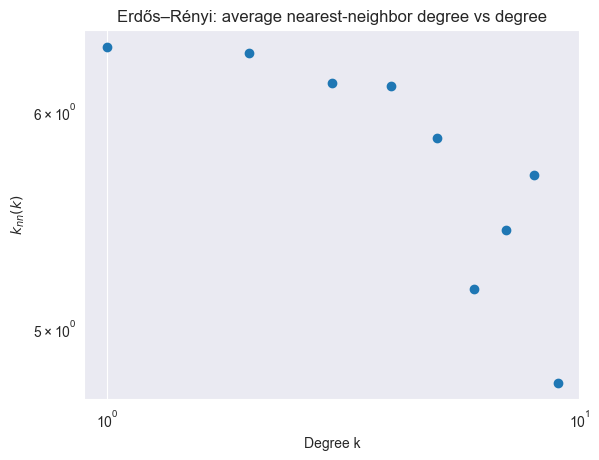

Erdős–Rényi
Degree k: [1 2 3 4 5 6 7 8 9]
Average neighbor degree k_nn(k): [6.33 6.3  6.14 6.12 5.87 5.17 5.43 5.69 4.78]
Deg correlation coefficient: -0.198
Mean degree (uncorrelated): 4.72
log–log slope ≈ -0.107



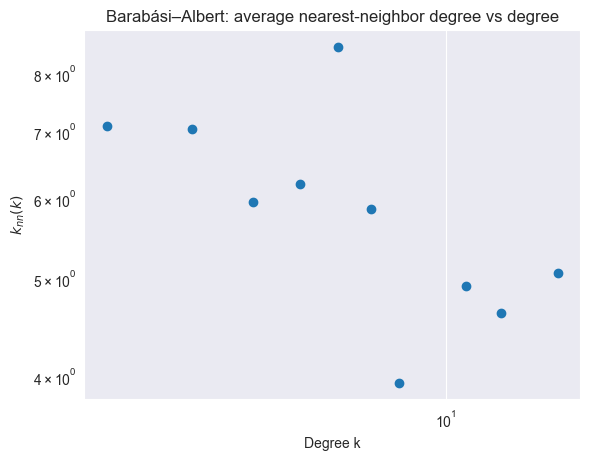

Barabási–Albert
Degree k: [ 2  3  4  5  6  7  8 11 13 17]
Average neighbor degree k_nn(k): [7.09 7.03 5.96 6.2  8.5  5.86 3.94 4.91 4.62 5.06]
Deg correlation coefficient: -0.176
Mean degree (uncorrelated): 3.84
log–log slope ≈ -0.225



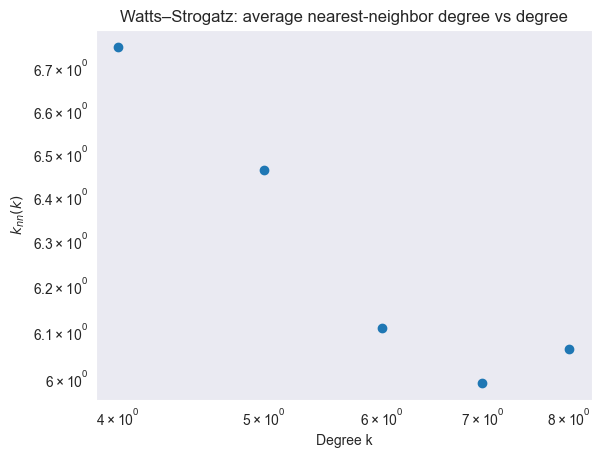

Watts–Strogatz
Degree k: [4 5 6 7 8]
Average neighbor degree k_nn(k): [6.75 6.46 6.11 5.99 6.06]
Deg correlation coefficient: -0.200
Mean degree (uncorrelated): 6.00
log–log slope ≈ -0.174



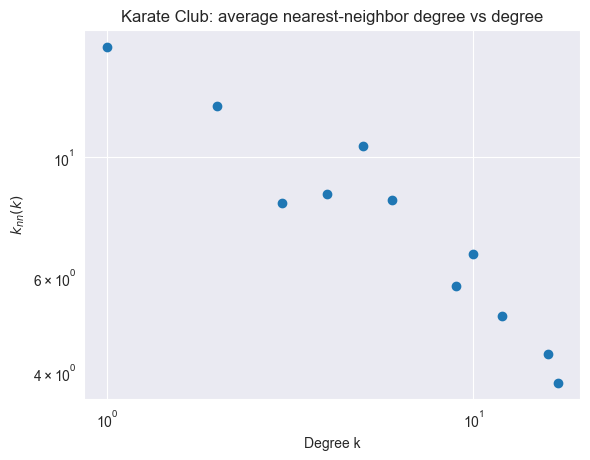

Karate Club
Degree k: [ 1  2  3  4  5  6  9 10 12 16 17]
Average neighbor degree k_nn(k): [16.   12.41  8.22  8.54 10.47  8.33  5.78  6.6   5.08  4.31  3.82]
Deg correlation coefficient: -0.476
Mean degree (uncorrelated): 4.59
log–log slope ≈ -0.471



In [48]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.linear_model import LinearRegression
import networkx as nx

def knn_by_degree(G):
    knn_node = nx.average_neighbor_degree(G)
    deg = dict(G.degree())
    bucket = defaultdict(list)
    for v, k in deg.items():
        if k > 0:
            bucket[k].append(knn_node[v])
    k_vals = np.array(sorted(bucket.keys()))
    knn_vals = np.array([np.mean(bucket[k]) for k in k_vals])
    return k_vals, knn_vals

def plot_knn(k_vals, knn_vals, title):
    plt.figure()
    plt.loglog(k_vals, knn_vals, marker='o', linestyle='none')
    plt.xlabel("Degree k")
    plt.ylabel(r"$k_{nn}(k)$")
    plt.title(title)
    plt.show()

def loglog_slope(k_vals, knn_vals, min_points=5):
    mask = (k_vals > 0) & (knn_vals > 0)
    x = np.log10(k_vals[mask]).reshape(-1, 1)
    y = np.log10(knn_vals[mask])
    if x.shape[0] >= min_points:
        lr = LinearRegression().fit(x, y)
        return lr.coef_[0], lr.intercept_
    return np.nan, np.nan

n = 50
p = 0.1
G_er = nx.erdos_renyi_graph(n, p, seed=1)
m = 2
G_ba = nx.barabasi_albert_graph(n, m, seed=1)
k_ws, p_ws = 6, 0.2
G_ws = nx.watts_strogatz_graph(n, k_ws, p_ws, seed=1)
G_karate = nx.karate_club_graph()

for name, G in [
    ("Erdős–Rényi", G_er),
    ("Barabási–Albert", G_ba),
    ("Watts–Strogatz", G_ws),
    ("Karate Club", G_karate),
]:
    k, knn = knn_by_degree(G)
    plot_knn(k, knn, f"{name}: average nearest-neighbor degree vs degree")
    assort = nx.degree_pearson_correlation_coefficient(G)
    slope, _ = loglog_slope(k, knn)
    degrees = np.array([d for _, d in G.degree()], dtype=float)
    mean_k = degrees.mean()
    print(name)
    print("Degree k:", k)
    print("Average neighbor degree k_nn(k):", np.round(knn, 2))
    print(f"Deg correlation coefficient: {assort:.3f}")
    print(f"Mean degree (uncorrelated): {mean_k:.2f}")
    print(f"log–log slope ≈ {slope:+.3f}\n")


### **# P4.3 – Conclusions**

Across all examined networks (ER, BA, WS, Karate Club) the function
**average nearest-neighbor degree** \(k_{nn}(k)\) **decreases with degree \(k\)**.
This indicates **disassortative mixing**: high-degree nodes tend to connect to low-degree nodes.

- **Erdős–Rényi**: almost flat \(k_{nn}(k)\), weakly disassortative.
- **Barabási–Albert**: clearly decreasing \(k_{nn}(k)\), typical for scale-free networks.
- **Watts–Strogatz**: slight decreasing trend due to random rewiring.
- **Karate Club**: strongest disassortativity; hubs connect mainly to low-degree nodes.

**Summary:** All networks show \(k_{nn}(k)\) decreasing with \(k\),  disassortative degree correlations, strongest in the real Karate Club network.


# P4.4
Check how random edge switching affects the result of the
previous task.


 Erdős–Rényi
Assortativity r (original): +0.004
Assortativity r (rewired x5): -0.008


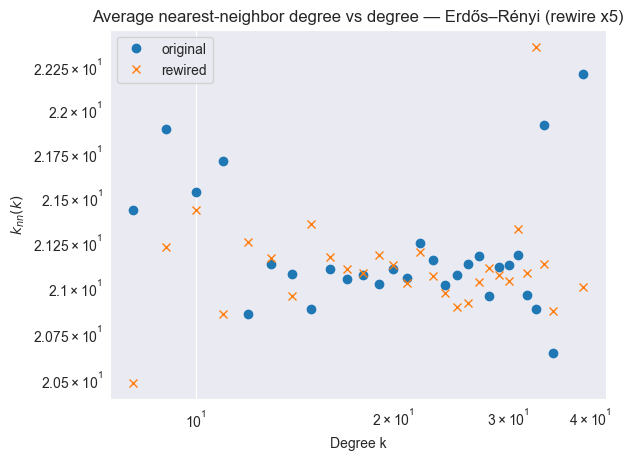

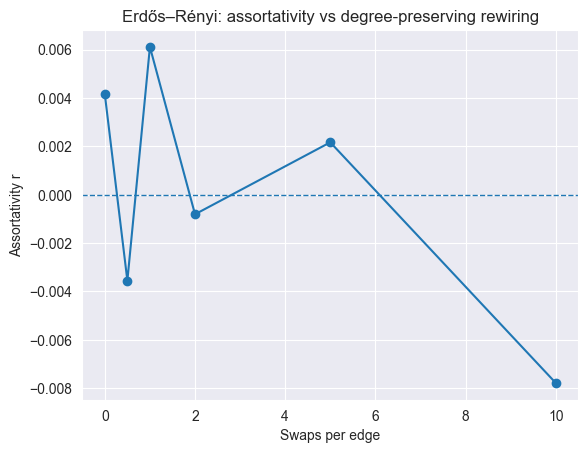


 Barabási–Albert
Assortativity r (original): -0.057
Assortativity r (rewired x5): -0.038


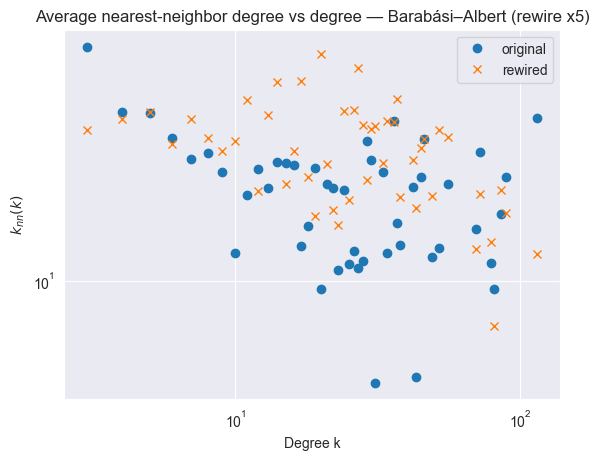

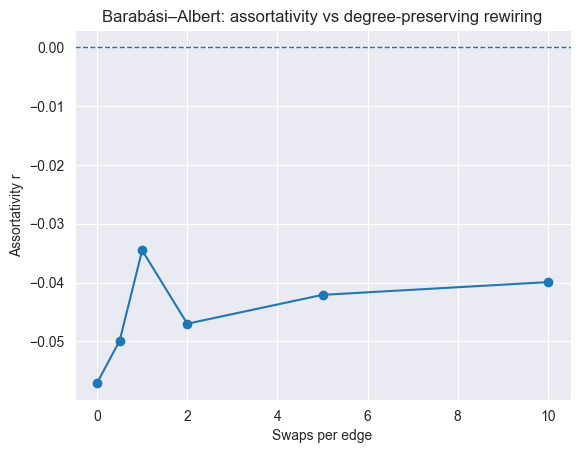


 Karate Club
Assortativity r (original): -0.476
Assortativity r (rewired x5): -0.350


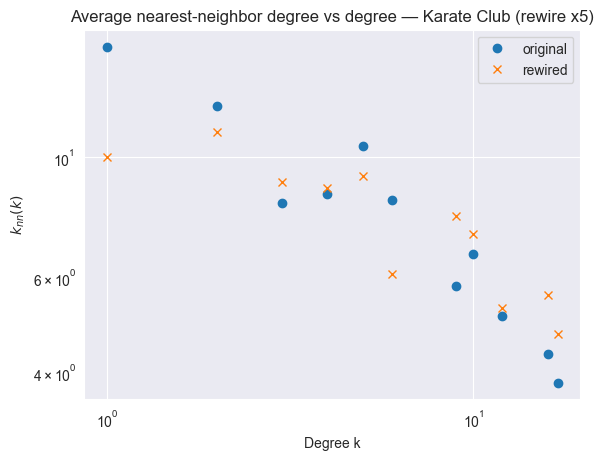

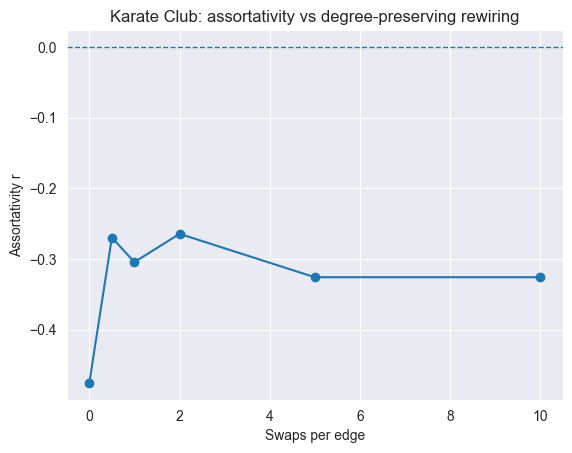

In [50]:
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx

def knn_by_degree(G):
    knn_node = nx.average_neighbor_degree(G)
    deg = dict(G.degree())
    buckets = defaultdict(list)
    for v, k in deg.items():
        if k > 0:
            buckets[k].append(knn_node[v])
    k_vals = np.array(sorted(buckets.keys()))
    knn_vals = np.array([np.mean(buckets[k]) for k in k_vals])
    return k_vals, knn_vals

def degree_preserving_rewire(G, swaps_per_edge=1.0, connected=False, seed=1):
    H = G.copy()
    m = H.number_of_edges()
    nswap = int(max(1, swaps_per_edge * m))
    rng = np.random.default_rng(seed)
    if connected and nx.is_connected(H):
        nx.connected_double_edge_swap(H, nswap=nswap, max_tries=nswap*10, seed=int(rng.integers(0, 1e9)))
    else:
        nx.double_edge_swap(H, nswap=nswap, max_tries=nswap*10, seed=int(rng.integers(0, 1e9)))
    return H

def plot_knn_curves(G_orig, G_rewired, title_suffix=""):
    k0, knn0 = knn_by_degree(G_orig)
    k1, knn1 = knn_by_degree(G_rewired)
    plt.figure()
    plt.loglog(k0, knn0, marker='o', linestyle='none', label='original')
    plt.loglog(k1, knn1, marker='x', linestyle='none', label='rewired')
    plt.xlabel("Degree k")
    plt.ylabel(r"$k_{nn}(k)$")
    plt.title(f"Average nearest-neighbor degree vs degree {title_suffix}")
    plt.legend()
    plt.show()

def sweep_rewiring_and_track(G, sweeps=(0, 0.5, 1, 2, 5, 10), connected=False):
    results = []
    for swe in sweeps:
        H = G if swe == 0 else degree_preserving_rewire(G, swe, connected=connected, seed=42)
        r = nx.degree_pearson_correlation_coefficient(H)
        results.append((swe, r))
    return np.array(results)

n = 2000
G_er = nx.erdos_renyi_graph(n, p=0.01, seed=1)
G_ba = nx.barabasi_albert_graph(n, m=3, seed=1)
G_karate = nx.karate_club_graph()

for name, G in [("Erdős–Rényi", G_er), ("Barabási–Albert", G_ba), ("Karate Club", G_karate)]:
    print(f"\n {name}")
    r0 = nx.degree_pearson_correlation_coefficient(G)
    print(f"Assortativity r (original): {r0:+.3f}")
    Grew = degree_preserving_rewire(G, swaps_per_edge=5, connected=False, seed=1)
    r1 = nx.degree_pearson_correlation_coefficient(Grew)
    print(f"Assortativity r (rewired x5): {r1:+.3f}")
    plot_knn_curves(G, Grew, title_suffix=f"— {name} (rewire x5)")

    sweeps = (0, 0.5, 1, 2, 5, 10)
    arr = sweep_rewiring_and_track(G, sweeps=sweeps, connected=False)
    plt.figure()
    plt.plot(arr[:,0], arr[:,1], marker='o')
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.xlabel("Swaps per edge")
    plt.ylabel("Assortativity r")
    plt.title(f"{name}: assortativity vs degree-preserving rewiring")
    plt.show()


# P4.6
Find the correlation coefficient for the network from task
P4.3-P4..4 (before and after edge switching). [1P]

In [42]:
import networkx as nx

def rewire_graph(G, swaps_per_edge=5, seed=42, connected=False):
    H = G.copy()
    m = H.number_of_edges()
    nswap = int(swaps_per_edge * m)

    if connected and nx.is_connected(H):
        nx.connected_double_edge_swap(H, nswap=nswap, seed=seed)
    else:
        nx.double_edge_swap(H, nswap=nswap, max_tries=10 * nswap, seed=seed)
    return H

def r_before_after(G, swaps_per_edge=5, trials=5, connected=False, base_seed=42):
    r_before = nx.degree_pearson_correlation_coefficient(G)
    rs = []

    for t in range(trials):
        Grew = rewire_graph(G, swaps_per_edge=swaps_per_edge, seed=base_seed + t, connected=connected)
        rs.append(nx.degree_pearson_correlation_coefficient(Grew))

    r_after_mean = float(np.mean(rs))
    r_after_std = float(np.std(rs))
    return r_before, r_after_mean, r_after_std

n = 2000
G_er = nx.erdos_renyi_graph(n, p=0.01, seed=1)
G_ba = nx.barabasi_albert_graph(n, m=3, seed=1)
G_ws = nx.watts_strogatz_graph(n, k=8, p=0.1, seed=1)
G_karate = nx.karate_club_graph()

for name, G, keep_conn in [
    ("Erdős–Rényi", G_er, False),
    ("Barabási–Albert", G_ba, False),
    ("Watts–Strogatz", G_ws, False),
    ("Karate Club", G_karate, True),
]:
    r0, r1_mean, r1_std = r_before_after(G, swaps_per_edge=5, trials=7, connected=keep_conn, base_seed=100)
    print(f"{name:16s} | r before = {r0:+.4f} | r after = {r1_mean:+.4f} ± {r1_std:.4f}")


Erdős–Rényi      | r before = +0.0042 | r after = -0.0030 ± 0.0083
Barabási–Albert  | r before = -0.0570 | r after = -0.0316 ± 0.0128
Watts–Strogatz   | r before = -0.0207 | r after = -0.0045 ± 0.0094
Karate Club      | r before = -0.4756 | r after = -0.3021 ± 0.0372


# P4.7
Let’s fil the above table with metrics od selected real networks,
use the built-in functions for counting the parameters. Compare
the results with the literature.

In [8]:
import numpy as np
import pandas as pd
import networkx as nx

def _as_pos_arr(x):
    x = np.asarray(x, dtype=float).ravel()
    return x[np.isfinite(x) & (x > 0)]

def estimate_alpha_degree_tail(G, min_tail=6):
    deg = np.array([d for _, d in G.degree()], float)
    x = _as_pos_arr(deg)

    if x.size < max(10, min_tail):
        return np.nan, np.nan, np.nan, int(x.size)

    x.sort()
    uniq = np.unique(x)
    best = dict(ks=np.inf, xmin=np.nan, alpha=np.nan, n_tail=0)

    for xm in uniq:
        tail = x[x >= xm]
        n = tail.size
        if n < min_tail:
            continue

        alpha = 1.0 + n / np.sum(np.log(tail / xm))

        F_emp = np.arange(1, n + 1) / n
        F_mod = 1.0 - (np.sort(tail) / xm) ** (-(alpha - 1.0))
        ks = np.max(np.abs(F_emp - F_mod))

        if ks < best["ks"]:
            best.update(ks=float(ks), xmin=float(xm), alpha=float(alpha), n_tail=int(n))

    if not np.isfinite(best["ks"]):
        return np.nan, np.nan, np.nan, 0
    return best["alpha"], best["xmin"], best["ks"], best["n_tail"]

def avg_path_length_gcc(G):
    if G.number_of_nodes() == 0:
        return np.nan
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    GCC = G.subgraph(comps[0]).copy()
    return nx.average_shortest_path_length(GCC)

def metrics_for_graph(name, G):
    N = G.number_of_nodes()
    E = G.number_of_edges()
    k_avg = 2 * E / N if N else np.nan
    r = nx.degree_pearson_correlation_coefficient(G)
    ell = avg_path_length_gcc(G)
    alpha, xmin, ks, n_tail = estimate_alpha_degree_tail(G, min_tail=6)

    return {
        "Network’s name": name,
        "↔?": "undirected",
        "N": N,
        "E": E,
        "⟨k⟩": k_avg,
        "α": alpha,
        "ℓ": ell,
        "r": r
    }

G_karate = nx.karate_club_graph()
G_florentine = nx.florentine_families_graph()
G_davis = nx.davis_southern_women_graph()

rows = []
rows.append(metrics_for_graph("Karate Club", G_karate))
rows.append(metrics_for_graph("Florentine Families", G_florentine))
rows.append(metrics_for_graph("Davis Southern Women (bipartite)", G_davis))

df = pd.DataFrame(rows)

display_df = df.copy()
for col in ["⟨k⟩","α","ℓ","r"]:
    display_df[col] = display_df[col].astype(float).round(3)

print(display_df.to_string(index=False))

display_df.to_csv("P4_7_real_networks_metrics.csv", index=False)
print("\nSaved: P4_7_real_networks_metrics.csv")


                  Network’s name         ↔?  N  E   ⟨k⟩     α     ℓ      r
                     Karate Club undirected 34 78 4.588 2.874 2.408 -0.476
             Florentine Families undirected 15 20 2.667 2.196 2.486 -0.375
Davis Southern Women (bipartite) undirected 32 89 5.562 2.708 2.306 -0.337

Saved: P4_7_real_networks_metrics.csv
